# Mixturas gaussianas usando NumPyro y variables latentes explícitas.

In [3]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC, init_to_median
import numpy as np
from numpyro.contrib.funsor import config_enumerate
from numpyro.ops.indexing import Vindex

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

### Para dibujar los resultados.
La siguiente es una función auxiliar para dibujar el contorno correspondiente a una derivación estándar de una distribución gaussiana bidimensional. Es la que se utilizó en el código visto en clase cuando se estudiaron las mezclas gaussianas.

In [4]:
def plot_gaussian_contour(mean, cov, ax=None):
    """
    Dibujar el contorno de una derivación estándar en una distribución gaussiana 2D.

    Entrada:
    mean : array-like, shape (2,)
        La media de la distribución gaussiana.
    cov : array-like, shape (2, 2)
        Matriz de covarianza de la distribución gaussiana.
    ax : matplotlib.axes.Axes, optional
        Los ejes en que pintar el dibujo. Si None, se crea una nueva figura.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Calcular autovalores y autovectores con eigh (optimizado para matrices simétricas)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Ángulo de rotación.
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

    # Ancho y alto de las dos desviación estándar (se corresponden con los autovalores).
    width, height = 2 * np.sqrt(eigenvalues)

    # Dibujar elipse.
    ellipse = Ellipse(xy=mean, width=width, height=height,
                      angle=angle, fill=False, color='blue')
    ax.add_artist(ellipse)

    return ax

### Datos de prueba.
Generamos los datos de prueba (como en el ejemplo de Barber visto en clase).

In [5]:
l = 0.2
r1 = 0.5

rng = np.random.default_rng(123)
X = np.zeros((2,100))
for r in range(100):
    rad = r1 + rng.uniform() * l
    theta = rng.uniform() * 2 * np.pi
    X[0,r] = rad * np.cos(theta)
    X[1,r] = rad * np.sin(theta)

## Primer modelo.
Vamos a construir dos modelos de la mixtura gaussiana. Son esencialmente iguales pero el primero (gaussian_noenum) no utiliza el mecanismo de enumeración de NumPyro para realizar la inferencia y ello simplifica el código. Se utiliza el algoritmo MixedHMC para realizar MCMC.

In [22]:
def gaussian_noenum(K, data=None):
    dim, num = data.shape

    # Muestreamos los pesos de las componentes.
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.ones(K)))

    # Muestreamos los elementos de las diagonales de las matrices de covarianzas.
    # Puesto que deben ser positivos, utilizamos la distribución Exponencial.
    with numpyro.plate("variables", dim):
        with numpyro.plate("components", K):
            sigmas = numpyro.sample("sigmas", dist.Exponential(1.0))  # shape (K, dim)

    # Medias de las componentes.
    with numpyro.plate('components', K):
        locs = numpyro.sample("locs", dist.Normal(0.0, 5.0).expand([dim]))

    with numpyro.plate('data', num):
        # Seleccionamos las componentes para cada uno de los puntos.
        assignment = numpyro.sample("assignment", dist.Categorical(weights))

        # Construimos la matriz de covarianzas para las normales asociadas a cada punto.
        # Estamos trabajando con matrices diagonales.
        cv = jnp.array([jnp.diag(s) for s in sigmas[assignment, :]])

        # Muestreamos de la mezcla.
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(locs[assignment, :], covariance_matrix=cv),
            obs=data.T,
        )

In [ ]:
# Inferencia con MCMC.
rng_key = random.PRNGKey(0)
num_warmup, num_samples = 400, 1400
num_components = 10
kernel = MixedHMC(HMC(gaussian_noenum))
mcmc = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
)
mcmc.run(rng_key, data=X, K=num_components)

### Dibujamos los resultados

In [ ]:
samples = mcmc.get_samples()
means = samples["locs"].mean(axis=0)
covariances = samples["sigmas"].mean(axis=0)

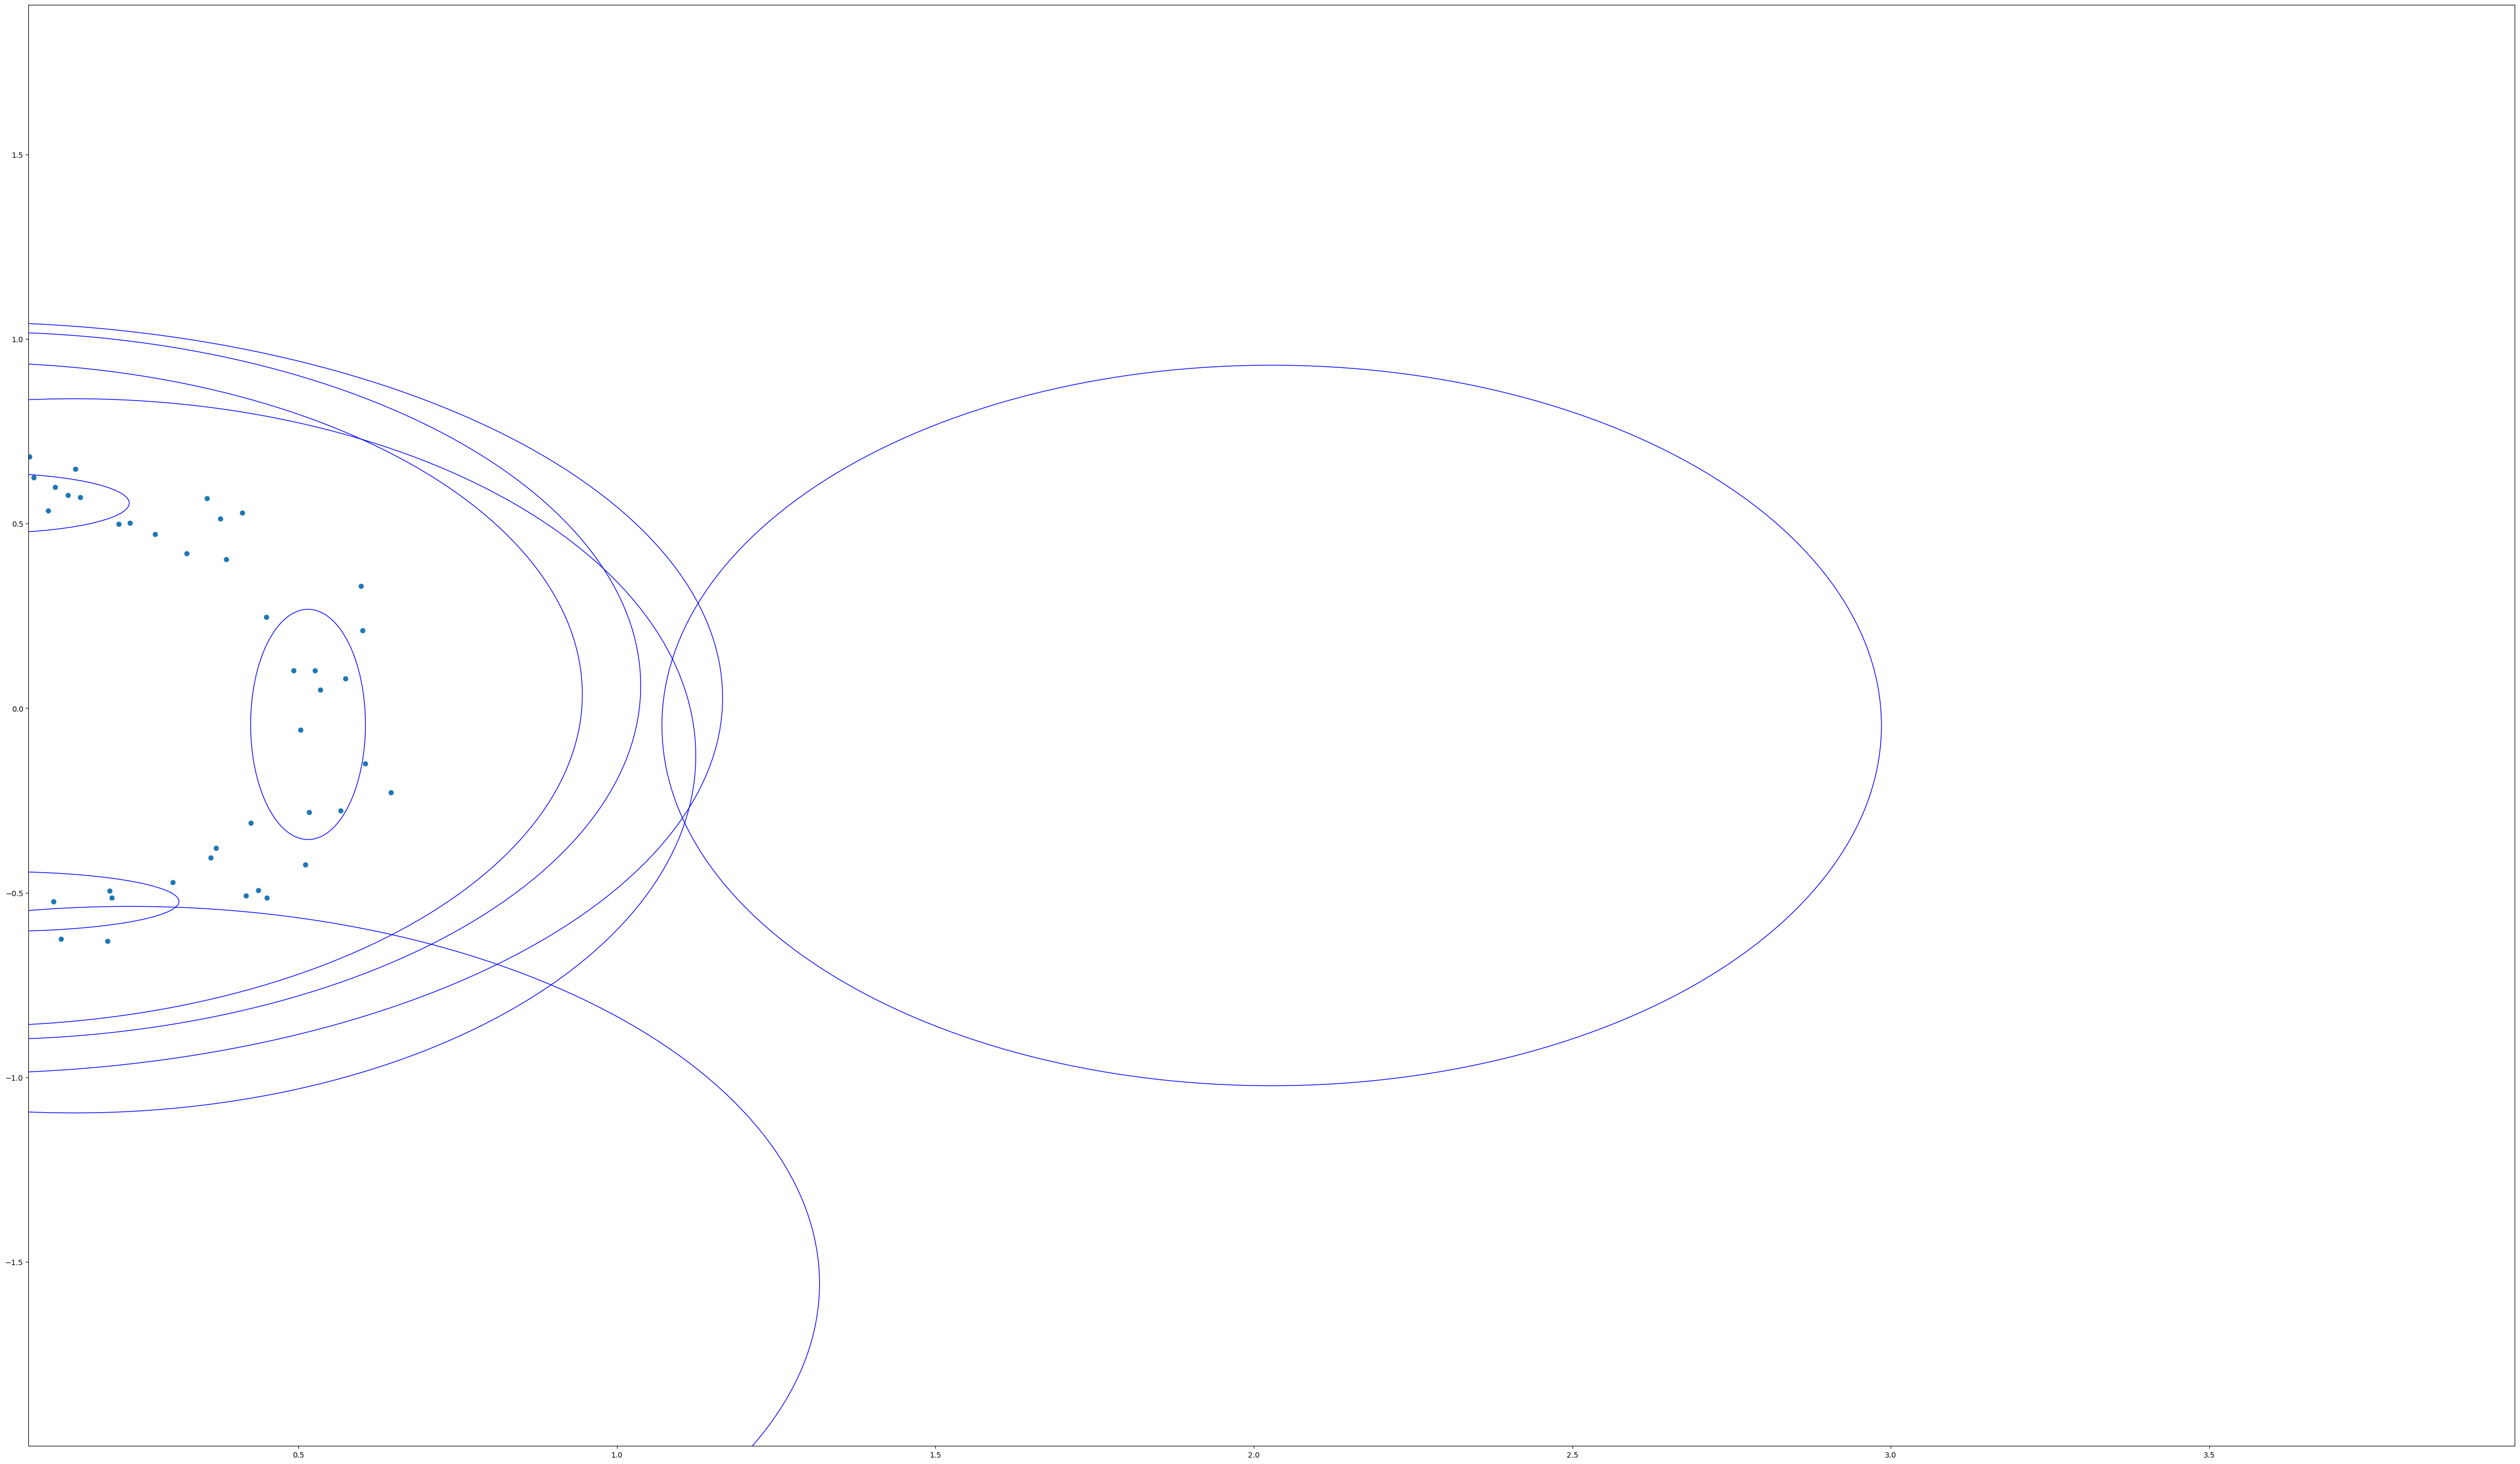

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(60, 35))

axes.plot(X[0,:], X[1,:],'o')
# Establecer límites para que las componentes se vean mejor (porque no ajustan bien).
axes.set_xlim(-1.6, 1.6)
axes.set_ylim(-1.6, 1.6)

for i in range(10):
    plot_gaussian_contour(means[i,:], covariances[i,:] * np.eye(2), axes)

plt.show()

A diferencia de lo que ocurría con el algoritmo EM, muchas componentes se quedan sin "concretar". Fijémonos en sus distintos pesos.

In [ ]:
w = samples["weights"].mean(axis=0)
print(w)

In [ ]:
# Quedémonos con los índices que los ordenarían (de mayor a menor)
ind = np.flip(np.argsort(w))

fig, axes = plt.subplots(1, 1, figsize=(60, 35))

# Pintemos las 4 componentes de mayor peso.
axes.plot(X[0,:], X[1,:],'o')
# Establecer límites para que las componentes se vean mejor (porque no ajustan bien).
axes.set_xlim(-1.6, 1.6)
axes.set_ylim(-1.6, 1.6)

for i in range(4):
    plot_gaussian_contour(means[ind[i],:], covariances[ind[i],:] * np.eye(2), axes)

plt.show()

## Segundo modelo.
El segundo modelo (gaussian_enum) utiliza el mecanismo de enumeración de NumPyro. Esto es simplemente una cuestión de implementación de la inferencia pero hace que haya que tener cuidado con la forma de los arrays.

En el código anterior, la variable "assignment" dentro del último "plate" inicialmente tiene forma (num,) (donde num es 100, el número de entradas) pero a la larga, por la enumeración, pasa a tener forma (10, 1, 1). El primer 10 representa los 10 posibles valores que puede tomar la asignación y las dimensiones adicionales las añade NumPyro para implementar la enumeración. Como consecuencia, la forma de "sigmas[assignment]" pasa de ser (100, 2) a ser (10, 1, 1, 2) y el código que tenemos para calcular las covarianzas deja de funcionar. Una posible solución es calcular las covarianzas de las componentes fuera de ese "plate", tras muestrear "sigmas".

El modelo viene decorado con @config_enumerate para evitar mensajes de error (aunque en la versión actual el código sigue funcionando). Se utiliza el algoritmo NUTS o HMC para realizar MCMC.

In [24]:
@config_enumerate
def gaussian_enum(K, data=None):
    dim, num = data.shape

    # Muestreamos los pesos de las componentes.
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.ones(K)))

    # Muestreamos los elementos de las diagonales de las matrices de covarianzas.
    with numpyro.plate("variables", dim):
        with numpyro.plate("components", K):
            sigmas = numpyro.sample("sigmas", dist.Exponential(1.0))  # shape (K, dim)

    # Calculamos las matrices de covarianza fuera del 'plate' de datos.
    cv = jnp.array([jnp.diag(sigma) for sigma in sigmas])  # shape (K, dim, dim)

    # Medias de las componentes.
    with numpyro.plate("components", K):
        locs = numpyro.sample("locs", dist.Normal(0.0, 5.0).expand([dim]))

    with numpyro.plate("data", num):
        # Seleccionamos las componentes para cada punto.
        assignment = numpyro.sample("assignment", dist.Categorical(weights))

        # Muestreamos de la mezcla usando las covarianzas y medias correspondientes.
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(locs[assignment, :], covariance_matrix=cv[assignment]),
            obs=data.T,
        )


In [ ]:
# Inferencia con MCMC.
rng_key = random.PRNGKey(0)
num_warmup, num_samples = 400, 1300
#kernel = HMC(model, step_size=.01, trajectory_length=1,
#             adapt_step_size=False, adapt_mass_matrix=False)
kernel = NUTS(gaussian_enum, init_strategy=init_to_median())
num_components = 10
mcmc = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
)
mcmc.run(rng_key, data=X ,K=num_components)

### Dibujamos los resultados.

In [ ]:
samples = mcmc.get_samples()
means = samples["locs"].mean(axis=0)
covariances = samples["sigmas"].mean(axis=0)

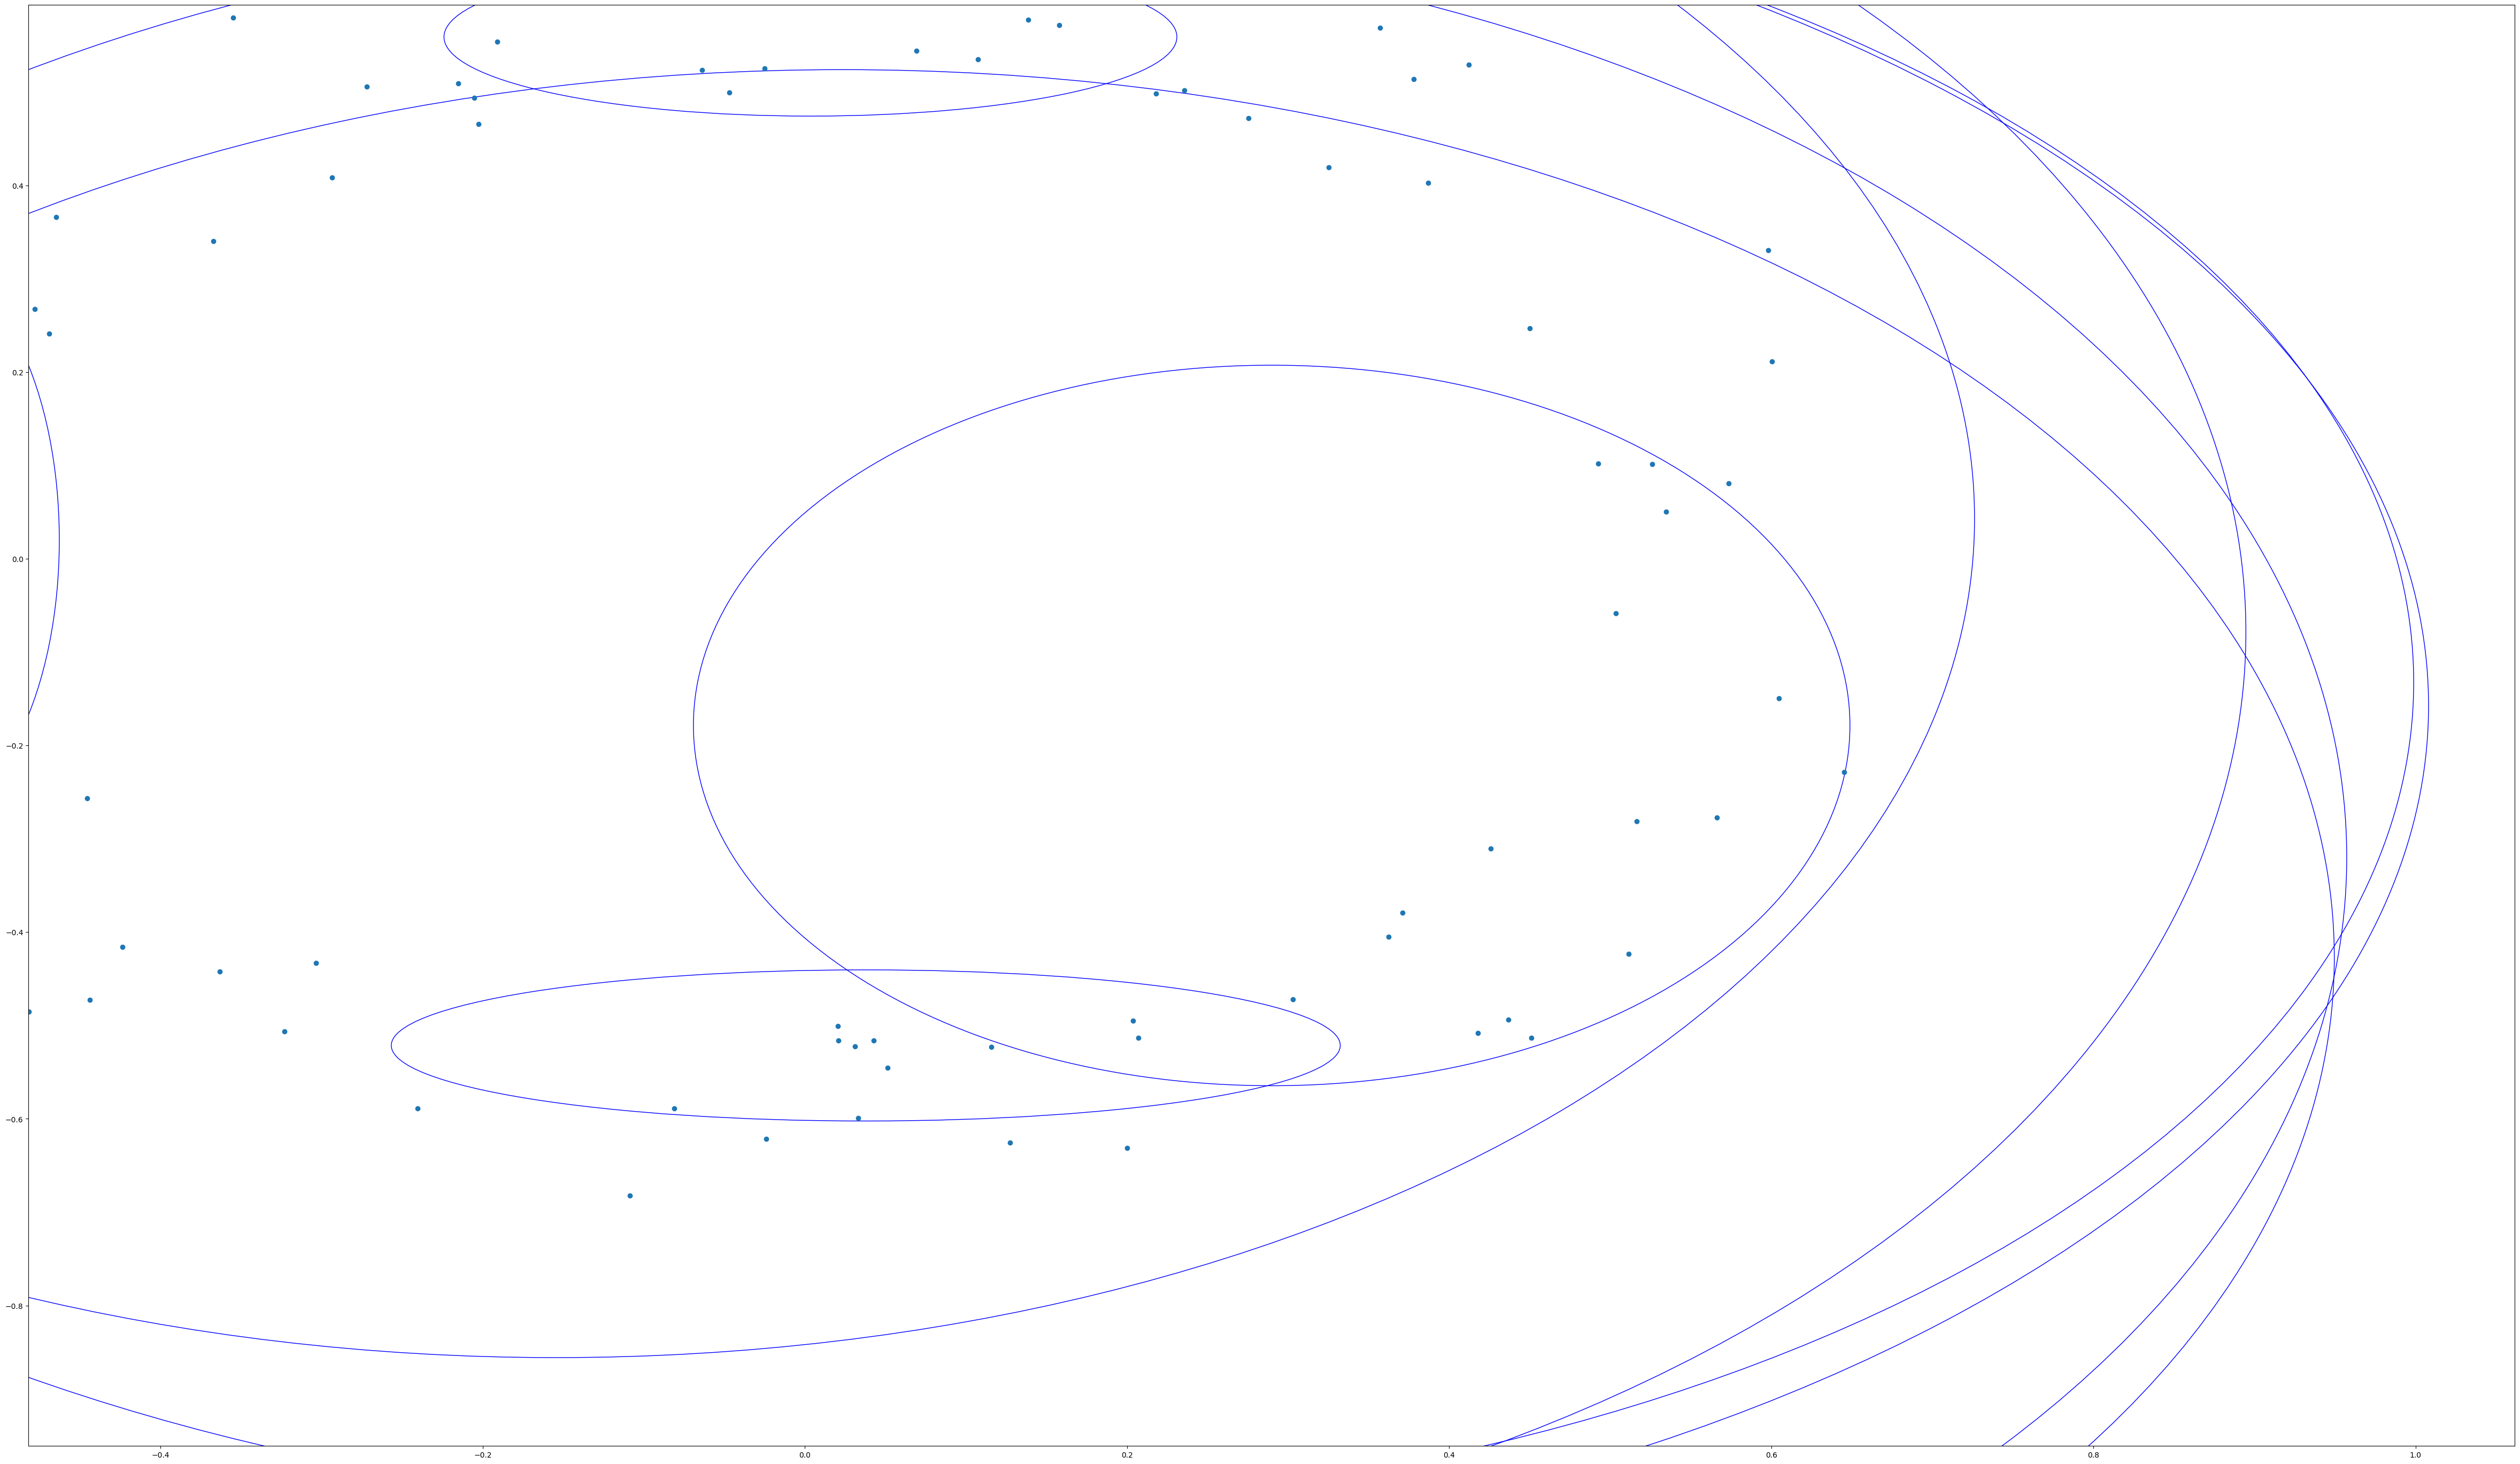

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(60, 35))

axes.plot(X[0,:], X[1,:],'o')
# Establecer límites para que las componentes se vean mejor (porque no ajustan bien).
axes.set_xlim(-1.6, 1.6)
axes.set_ylim(-1.6, 1.6)

for i in range(10):
    plot_gaussian_contour(means[i,:], covariances[i,:] * np.eye(2), axes)

plt.show()